In [1]:
# Cell 1: imports and autoreload
%load_ext autoreload
%autoreload 2

import os
import getpass
import logging
import numpy as np
import matplotlib.pyplot as plt
import roboticstoolbox as rtb
import spatialmath as sm
import spatialgeometry as sg
from IPython.display import display, clear_output

from pandaSim.geometry.rtb_adapter import RoboticsToolboxAdapter
from pandaSim.geometry.utils import create_virtual_panda, plot_joint_trajectories
from pandaSim.planning.screw_motion_planner import ScrewMotionPlanner
from pandaSim.control.qp import QPController

import panda_py
from panda_py import libfranka
from panda_py import controllers


logging.basicConfig(level=logging.INFO)

[I 08/09/25 13:46:17.135 6343] [shell.py:_shell_pop_print@23] Graphical python shell detected, using wrapped sys.stdout


In [ ]:
# Panda hostname/IP and Desk login information of your robot
hostname = os.getenv("PANDA_HOST") or input("Panda hostname/IP: ").strip()
username = os.getenv("PANDA_USER") or input("Desk Username: ").strip() 
password = os.getenv("PANDA_PASS") or getpass.getpass("Desk Password: ")
desk = panda_py.Desk(hostname, username, password, platform='panda')


INFO:desk:Login succesful.
INFO:desk:Retaken control.


In [139]:
desk.lock()

In [ ]:
desk.unlock()
panda_real = panda_py.Panda(hostname)
panda_real.move_to_start()

INFO:panda:Connected to robot (172.16.0.2).
INFO:panda:Panda class destructor invoked (172.16.0.2).
INFO:panda:Stopping active controller (JointTrajectory).


In [105]:

adapter = RoboticsToolboxAdapter({
    "realtime": True,
    "rate": 100,
    "browser": 'google-chrome' # "notebook" for visualizing in jupyter notebook
})
    
planner = ScrewMotionPlanner(adapter=adapter)

panda_path = '../model/franka_description/robots/frankaEmikaPandaVirtual.urdf'
panda_sim = create_virtual_panda(urdf_path=panda_path)

# Add the axes to the environment
n = panda_real.q.shape[0]
panda_sim.q[:n] = panda_real.q[:n]

env = adapter.env

# Open the gripper fingers (from sample code)
if hasattr(panda_sim, 'grippers') and len(panda_sim.grippers) > 0:
    panda_sim.grippers[0].q = [0.035, 0.035]
    
box = sg.Box(scale=[0.2, 0.07, 0.3], 
             color='blue', 
             pose=sm.SE3(0.7, 0, 0.05))


# end-effector axes
ee_axes = sg.Axes(0.1)

wTe = adapter.forward_kinematics(robot=panda_sim, 
                                       link='panda_finger_virtual', 
                                       output_type='t')
ee_axes.T = wTe
# goal axes
goal_axes = sg.Axes(0.1)

grasp_pose, qs, s_axes = planner.compute_grasp(obj=box, 
                                               adapter=adapter, 
                                               grasp_height='top',
                                               prefer_closer_grasp=True, 
                                               gripper_offset=sm.SE3.Rx(np.pi/2).A, 
                                               output_type='t')
wTg = grasp_pose
wTb = box.T
gTb = np.linalg.inv(wTg) @ wTb
goal_axes.T = wTg

env.add(ee_axes)
env.add(goal_axes) 
env.add(panda_sim)
env.add(box)

def reset_env():
    panda_sim.q[:n] = panda_real.q[:n]
    panda_sim.grippers[0].q = [0.035, 0.035]
    box.T = sm.SE3(0.7, 0, 0.05)
    ee_axes.T = adapter.forward_kinematics(robot=panda_sim, 
                                        link='panda_finger_virtual', 
                                        output_type='t')
    goal_axes.T = wTg


INFO:websockets.server:server listening on 127.0.0.1:53004
INFO:websockets.server:connection open


In [106]:
# Direct instantiation
from pandaSim.control import QPController

controller = QPController(adapter=adapter, 
                          robot=panda_sim,
                          end_effector_link='panda_finger_virtual', 
                          gains_translation=1.0, 
                          gains_rotation=0.5, 
                          threshold=0.001, 
                          lambda_q=0.5, 
                          lambda_m=1.0, 
                          lambda_j=0.1,
                          ps=0.5, 
                          pi=0.3, 
                          eta=1.0, 
                          solver='quadprog',
                          T=5)



In [107]:
panda_real.move_to_start()

INFO:panda:Initializing motion generation (moveToJointPosition).
INFO:motion:Computed joint trajectory: 1 waypoint, duration 0.14 seconds.
INFO:panda:Starting new controller (JointTrajectory).


True

# Simulation

In [108]:
def execute_velocity_trajectory(qd_traj: np.ndarray, 
                                panda_real: panda_py.Panda, 
                                panda_sim: rtb.models.Panda, 
                                adapter: RoboticsToolboxAdapter, 
                                sim_dt: float=0.01, 
                                log_size: int=5000, 
                                freq: int=100,
                                move_to_start: bool=True):
    """
    Runs the real robot with a given joint velocity trajectory (qd_traj).
    Also updates the simulation to match the real robot's state.

    Args:
        qd_traj: Iterable of joint velocity commands (shape: [steps, n_joints])
        panda_real: The real robot interface object
        panda_sim: The simulation robot object
        adapter: Adapter object for simulation stepping and joint limits
        controllers: Module or object containing the IntegratedVelocity controller
        n: Number of joints to control
        sim_dt: Simulation timestep (default: 0.01)
        log_size: Number of log entries for enable_logging (default: 5000)
        freq: Control frequency for context (Hz, default: 100)
        move_to_start: Whether to move the robot to the start configuration (default: True)

    Returns:
        log: Log of the real robot
        time_history: Time history of the real robot
    """
    if move_to_start:
        panda_real.move_to_start()
    

    n = panda_real.q.shape[0]
    panda_sim.q[:n] = panda_real.q[:n]
    adapter.step_simulation(sim_dt)
    ctrl = controllers.IntegratedVelocity()
    time_history = []
    panda_real.start_controller(ctrl)
    panda_real.enable_logging(log_size)
    with panda_real.create_context(frequency=freq) as ctx:
        if ctx.ok():
            for qd_c in qd_traj: 
                ctrl.set_control(qd_c[:n])
                time_history.append(ctrl.get_time())
                panda_sim.q[:n] = panda_real.q[:n]
                adapter.step_simulation(sim_dt)
            
            
    
    panda_real.disable_logging()
    time_history = np.array(time_history)
    panda_real.stop_controller()
    
    return panda_real.get_log(), time_history

In [40]:
task_time = 10.0
twist_b = planner.generate_twist_trajectory(body_pose=grasp_pose,
                                            q=qs, 
                                            s_axis=s_axes, 
                                            theta=np.pi/2, 
                                            h=0.0, 
                                            theta_dot=0.1,
                                            Tf=task_time, 
                                            time_scaling='quintic', 
                                            body_coordinate=True)

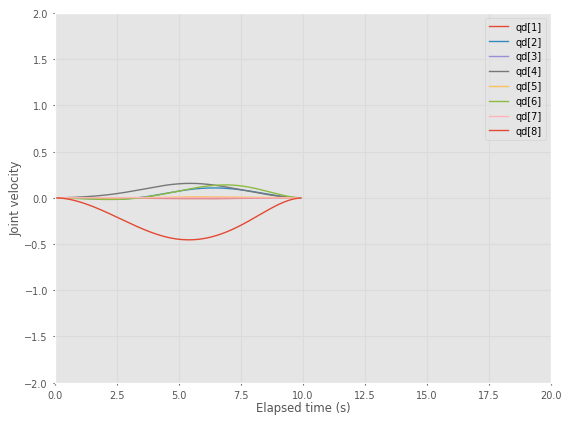

In [49]:

panda_sim.q = q_arrived
arrived = False

qd_manipulate = []
q_manipulate = []
time_history = []

elapsed_time = 0.0
fig, ax, lines = None, None, None

step = 0
for twist in twist_b:
    qd, arrived = controller.compute_joint_velocities(twist=twist, optimization_type="joint_limit")
    goal_axes.T = grasp_pose
    # qd = controller.smooth_velocity_ramp(qd_cmd=qd, elapsed_time=elapsed_time, method="quintic")
    adapter.control_joint_velocities(panda_sim, qd)
    wTe = panda_sim.fkine(panda_sim.q, end='panda_finger_virtual')
    ee_axes.T = wTe
    
    box.T = wTe * gTb #SE3
    adapter.step_simulation(dt)
    qd_manipulate.append(qd[:panda_sim.n].copy())
    q_manipulate.append(panda_sim.q[:panda_sim.n].copy())
    elapsed_time += dt
    time_history.append(elapsed_time)

    if step % 10 == 0:  # update plot every 0.1 seconds for speed
        fig, ax, lines = plot_joint_trajectories(
            time_history, 
            qd_manipulate, 
            n_joints=panda_sim.n,
            ylabel="Joint velocity",
            fig=fig, ax=ax, lines=lines,
            labels=[f'qd[{i+1}]' for i in range(panda_sim.n)],
            animate=True,
            ylim=(-2, 2)
        )
    step += 1

qd_manipulate = np.array(qd_manipulate)
time_history = np.array(time_history)


ax.set_title('Joint Velocities Over Time')
ax.legend(loc='upper right', ncol=2)
plt.ioff()
plt.show()

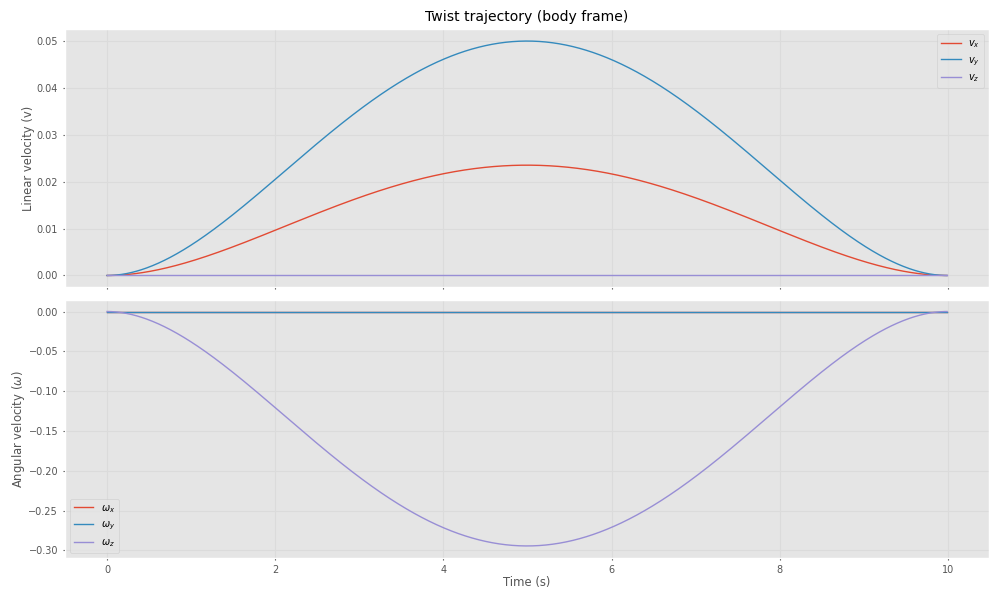

In [50]:
# Plot twist_b: (v, omega) order, shape (N, 6)
time_twist = np.arange(len(twist_b)) * dt
labels = [r'$v_x$', r'$v_y$', r'$v_z$', r'$\omega_x$', r'$\omega_y$', r'$\omega_z$']
ylabels = ['Linear velocity (v)', 'Angular velocity ($\omega$)']

fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
for i in range(3):
    axes[0].plot(time_twist, twist_b[:, i], label=labels[i], linewidth=1)
    axes[1].plot(time_twist, twist_b[:, i+3], label=labels[i+3], linewidth=1)

for ax, ylabel in zip(axes, ylabels):
    ax.set_ylabel(ylabel)
    ax.legend()
axes[1].set_xlabel('Time (s)')
axes[0].set_title('Twist trajectory (body frame)')
plt.tight_layout()
plt.show()


In [138]:
panda_real.move_to_start()

INFO:panda:Stopping active controller (Integrated Velocity).
INFO:panda:Initializing motion generation (moveToJointPosition).
INFO:motion:Computed joint trajectory: 1 waypoint, duration 3.49 seconds.
INFO:panda:Starting new controller (JointTrajectory).


True

In [119]:
import matplotlib.pyplot as plt
from IPython.display import display, clear_output


panda_real.move_to_start()
dt = adapter.dt
panda_sim.q[:n] = panda_real.q[:n]
adapter.step_simulation(dt)
arrived = False

qd_approach = []
q_approach = []
manipulability_measure = []
time_history = []

dt = adapter.dt
elapsed_time = 0.0

# Initialize fig, ax, lines to None for first call
fig = None
ax = None
lines = None

step = 0


INFO:panda:Stopping active controller (Integrated Velocity).
INFO:panda:Initializing motion generation (moveToJointPosition).
INFO:motion:Computed joint trajectory: 1 waypoint, duration 3.49 seconds.
INFO:panda:Starting new controller (JointTrajectory).


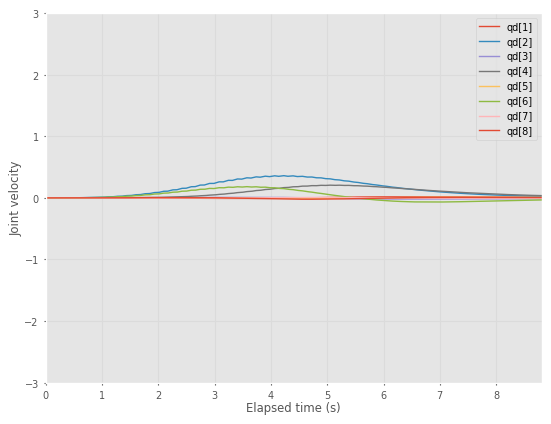

INFO:panda:Stopping active controller (Integrated Velocity).


In [ ]:

ctrl = controllers.IntegratedVelocity()
panda_real.start_controller(ctrl)
panda_real.enable_logging(15000)


with panda_real.create_context(frequency=1e2, max_runtime=15) as ctx:
    
    while ctx.ok() and not arrived:
        panda_sim.q[:n] = panda_real.q[:n]
        
        qd, arrived = controller.compute_joint_velocities(grasp_pose, optimization_type="j")
        goal_axes.T = grasp_pose
        qd = controller.smooth_velocity_ramp(qd_cmd=qd, elapsed_time=elapsed_time, method="quintic")

        ctrl.set_control(velocity=qd[:n])

        adapter.control_joint_velocities(panda_sim, qd)
        
        ee_axes.T = panda_sim.fkine(panda_sim.q, end='panda_finger_virtual')
        adapter.step_simulation(dt)
        qd_approach.append(qd[:panda_sim.n].copy())
        q_approach.append(panda_sim.q[:panda_sim.n].copy())
        elapsed_time += dt
        time_history.append(ctrl.get_time())
        if step % 10 == 0:  # update plot every 0.1 seconds for speed
            fig, ax, lines = plot_joint_trajectories(
                time_history, 
                qd_approach, 
                panda_sim.n, 
                ylabel="Joint velocity", 
                labels=[f'qd[{i+1}]' for i in range(panda_sim.n)],
                ax=ax, fig=fig, lines=lines, 
                elapsed_time=elapsed_time, 
                animate=True, 
                xlim_window=5, 
                ylim=(-3, 3)
            )
        step += 1

panda_real.stop_controller()
panda_real.disable_logging()
time_history = np.array(time_history)
q_arrived = panda_sim.q.copy()

plt.ioff()
plt.show()


dict_keys(['K_F_ext_hat_K', 'O_F_ext_hat_K', 'O_T_EE', 'control_command_success_rate', 'dq', 'elbow', 'q', 'tau_J', 'tau_ext_hat_filtered', 'time'])

In [ ]:
log_approached = panda_real.get_log()
qd_approached = np.array(log_approached['dq'])
time_history = np.linspace(0, max(time_history), len(log_approached['dq']))


((14967, 7), (14967,))

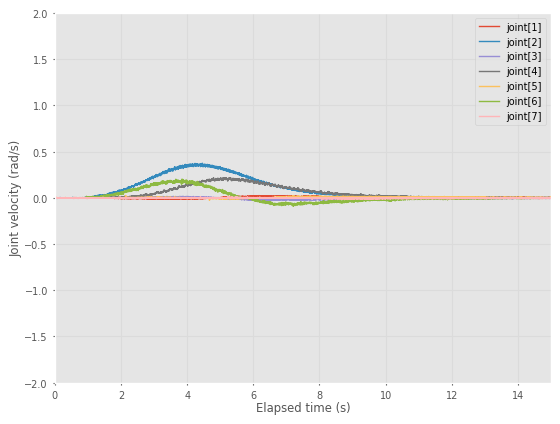

In [137]:


qd_approached = np.array(log_approached['dq'])
fig, ax, lines = plot_joint_trajectories(
    time_history=time_history,
    data_history=qd_approached,
    n_joints=n,
    ylabel="Joint velocity (rad/s)",
    labels=[f'joint[{i+1}]' for i in range(n)],
    animate=False
)

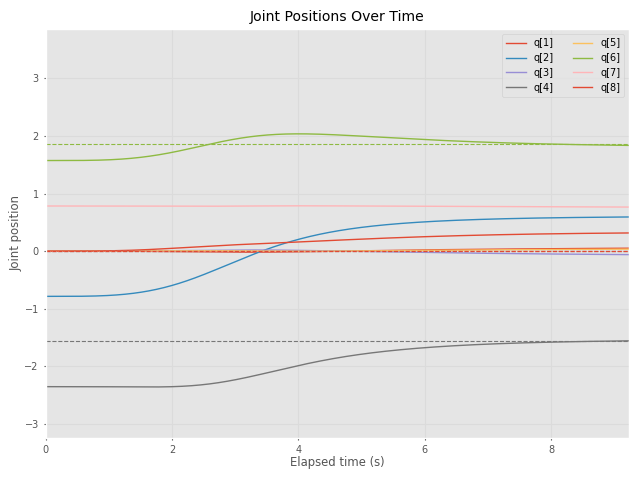

In [ ]:
q_approach = np.array(q_approach)
time_history = np.array(time_history)
manipulability_measure = panda_sim.manipulability(q=q_approach)
# Get joint limits
q_min, q_max = adapter.get_joint_limits(panda_sim)

# Plot joint positions using the utility function
fig2, ax2, lines2 = plot_joint_trajectories(
    time_history,
    q_approach,
    n_joints=q_approach.shape[1],
    ylabel="Joint position",
    labels=[f'q[{i+1}]' for i in range(q_approach.shape[1])],
    animate=False,
    ylim=(np.min(q_min)-0.1, np.max(q_max)+0.1)
)

# Overlay middle joint limits as dashed lines
for i, line in enumerate(lines2):
    color = line.get_color()
    q_mid = (q_min[i] + q_max[i]) / 2
    ax2.hlines(q_mid, time_history[0], time_history[-1], colors=color, linestyles='dashed', linewidth=0.8)

ax2.set_title('Joint Positions Over Time')
ax2.legend(loc='upper right', ncol=2)
fig2.tight_layout()
clear_output(wait=True)
display(fig2)


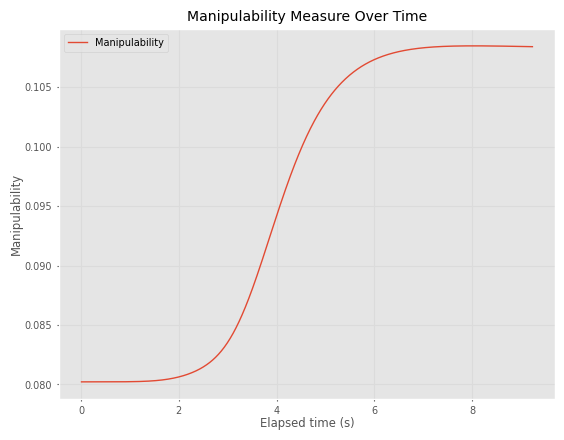

In [ ]:
# Plot manipulability measure history over time
fig3, ax3 = plt.subplots()
ax3.plot(time_history, manipulability_measure, label='Manipulability', linewidth=1)
ax3.set_xlabel('Elapsed time (s)')
ax3.set_ylabel('Manipulability')
ax3.set_title('Manipulability Measure Over Time')
ax3.legend()
plt.show()

# Experiment

In [109]:
log_approach, time_history = execute_velocity_trajectory(qd_traj=qd_approach, 
                            panda_real=panda_real, 
                            panda_sim=panda_sim, 
                            adapter=adapter,
                            sim_dt=dt,
                            log_size=15000,
                            freq=100,
                            move_to_start=True)

ee_axes.T = adapter.forward_kinematics(robot=panda_sim, 
                                       link='panda_finger_virtual', 
                                       output_type='t')
adapter.step_simulation(dt)



qd = log_approach['qd']  # shape: (N, 7)

fig, ax, lines = plot_joint_trajectories(
    time_history=time_history,
    data_history=qd,
    n_joints=qd.shape[1],
    ylabel="Joint velocity (rad/s)",
    labels=[f'joint[{i+1}]' for i in range(qd.shape[1])],
    animate=False
)


INFO:panda:Stopping active controller (JointTrajectory).


INFO:panda:Initializing motion generation (moveToJointPosition).
INFO:motion:Computed joint trajectory: 1 waypoint, duration 0.07 seconds.
INFO:panda:Starting new controller (JointTrajectory).
INFO:panda:Stopping active controller (JointTrajectory).
INFO:panda:Starting new controller (Integrated Velocity).
INFO:panda:Stopping active controller (Integrated Velocity).


KeyError: 'qd'

In [ ]:
execute_velocity_trajectory(qd_traj=qd_manipulate, 
                            panda_real=panda_real, 
                            panda_sim=panda_sim, 
                            adapter=adapter,
                            sim_dt=dt,
                            log_size=5000,
                            freq=100,
                            move_to_start=False)